# Plot Concentration Bound
---

## Geometry of $\mathcal{X}\times \mathcal{Y}$: 
### Set the Rate at Which Embedding Distorts Geometry in As a Function of Euclidean Dimension

We consider four possible cases (``distortion_type``):
1. Worst-case (expander graph-type geometries)
2. Polynomial embedding (trees).
3. Subsets of Euclidean space.
4. Subspaces (metric) of the real line.

In [255]:
distortion_type = 3

### Decide on N vs k

### N

In [256]:
N = 1*(10**3)
N_is_Small = True

### k

#### Either we set k manually or we consider the no. Points Needed to Pack a Cube:

From [George G. Lorentz, Manfred v. Golitschek, and Yuly Makovoz. Constructive approximation - Proposition 1.3](https://link.springer.com/book/9783642646102) the packing number of $[0,\operatorname{diam}]^d$ in $\ell_{\infty}^d$ by $\ell_{\infty}^d$-balls of radius $10^{-p}$ is no more than
$$
k \ge 
\Big\lceil
2^{-d}
        \,
        \Big(10^{p}*\operatorname{diam}\Big)^d
\Big\rceil
$$
we use this lower-bound to compute $k$.

In [274]:
# Cube or no Cube?
cube_k = True

# If Cube
diam = 1*(10**0)
d = 1*(10**2); print('Prototypical Space: [0,'+str(diam)+']^'+str(d))
p = 1*(10**0); print('Distance Between Points on the Grid: '+str(10**-p))

# If Manual 
k_manual = 1*(10**8)

Prototypical Space: [0,1]^100
Distance Between Points on the Grid: 0.1


## Import Packages and Set Global Hyperparameters

In [275]:
%run ./SupportFiles/Dependancies.ipynb
print('---')

Dependancies and Packages Loaded
---


# Set Global Parameters

## Are we Computing Risk Bounds or Concentration Bounds (in $\mathcal{W}_1$)?
- For Risk Bounds set: True
- For Concentration Bounds set: False

In [276]:
Risk_or_Concentration = True
Isometric_Embedding = True

#### Decide on How Many Points to Use?

In [277]:
if cube_k:
    k = round( ( 2**(-d) ) * ((diam*(10**(p))**d)) ); print('Number of points:'+str(k))
else:
    k = k_manual

Number of points:7888609052210118179568976417591761882603167107907294485042182806831104


Load Global hyperparameters, now that internal parameters have been defined.

In [278]:
%run ./SupportFiles/Global_Hyperparameters.ipynb
print('---')

Results are to Hold with Probability at-least: 95.0%
We consider: 1-Lipschitz Hypotheses
Max Representation Space Dimension (F aka m): 4.605170185988092
---


---

Load helper functions.

In [279]:
print('---')
%run ./SupportFiles/Helper_Functions.ipynb
print('---')

---
Helper Functions Loaded
---


# The Risk Bound Computers

We compare our risk bound against the following binary classification benchmarks.

## Benchmark: Trivial VC/Occam Bound (Binary Classification)
From the The (Quantitative) Fundamental Theorem of Statistical Learning ([Theorem 6.8 in "Understanding Machine Learning" (with extra details in Section 28.1)](https://scholar.google.com/citations?view_op=view_citation&hl=en&user=kezPqwoAAAAJ&citation_for_view=kezPqwoAAAAJ:XiVPGOgt02cC)
$$
\begin{aligned}
    \mathcal{R}(f) - \hat{\mathcal{R}}(f)
\le &
    n^{-1/2}
    (
        128 \operatorname{VC-dim}\log(n+1) + \log(8/\delta)
    )^{1/2}
\\ 
\le & 
    n^{-1/2}
    (
        128 \#\mathcal{X}\log(n+1) + \log(8/\delta)
    )^{1/2}
\end{aligned}
$$
where we use the fact that $\operatorname{VC-dim}(2^{\mathcal{X}})\le \log_2(\#2^{\mathcal{X}})=\#\mathcal{X}$.

## Hoeffding Bound


From [Corollary 4.6 of "Understanding Machine Learning"](https://scholar.google.com/citations?view_op=view_citation&hl=en&user=kezPqwoAAAAJ&citation_for_view=kezPqwoAAAAJ:XiVPGOgt02cC) we have the following Heofding-type bound
$$
\begin{aligned}
    (2n)^{-1/2}
    \log\big(
    2 \times 2^k/\delta
    \big)^{1/2}
    = 
    (2n)^{-1/2}
     \big(
     \log(2/\delta) + k\log(2)
     \big)^{1/2}
\end{aligned}
$$

Load risk bound functions.

In [280]:
%run ./SupportFiles/Risk_Bound_Engine.ipynb

Risk Bounds Loaded


## Generate Plot

#### Decide on Scale of Sample Size (Range: Small N or Large N)

In [288]:
# Indices
indexing_set = range(100,1000,50)

In [292]:
Print_Occam = False

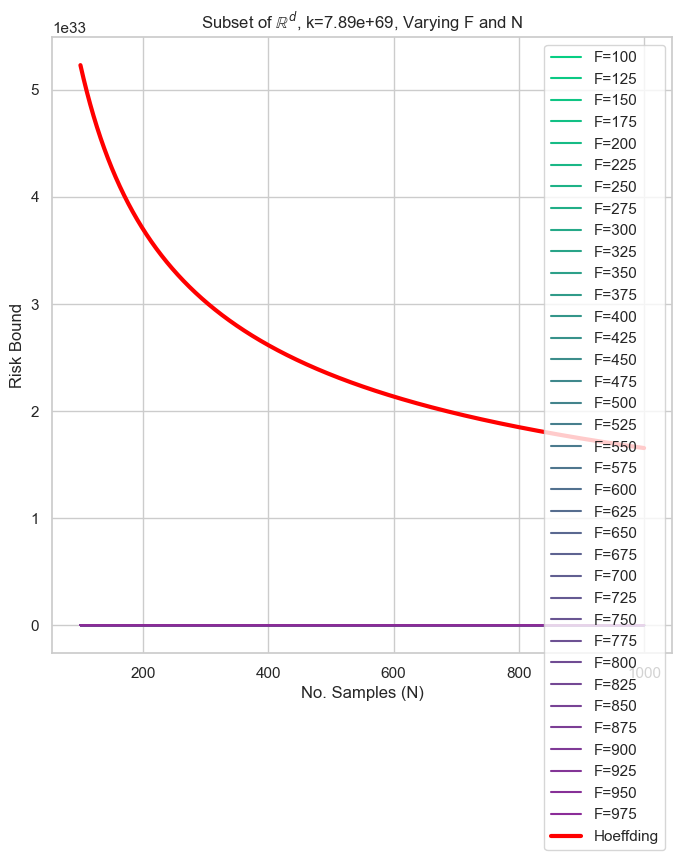

In [293]:
plt.figure(figsize=(8,8))
sns.set_style("whitegrid")

plt.title(''+dist_name+', k='+str('{:.2e}'.format(k))+', Varying F and N')
    

plt.xlabel('No. Samples (N)')
plt.ylabel('Risk Bound')# on $\sup_{f\in \mathcal{F}}\,|\mathcal{R}(\hat{f})-\hat{\mathcal{R}}(\hat{f})|$')
# plt.ylabel('Bound on $\mathbb{E}[\mathcal{W}_1(\mathbb{P},\mathbb{P}^N)]$')



# Set Max No Colours
n_col=max(indexing_set)+2


#### Plot Generation
for i in indexing_set:
    # Set Value of F
    F_global = int(np.round(i,0))
    
    # Write Function of N only
    def get_risk_bound__NVar_scalar(N):
        return get_risk_bound__scalar(k=k_global,F=F_global,N=N)
    
    get_risk_bound__NVar = np.vectorize(get_risk_bound__NVar_scalar)
    
    # Compute Risk Bound
    Risk_Bounds = get_risk_bound__NVar_scalar(N_sequence)

    
    # Plot
    col_index = (i-min(indexing_set))/(max(indexing_set)+1)
    plt.plot(N_sequence, Risk_Bounds,label = 'F='+str(F_global).format(i=i),color=colorFader(c1,c2,col_index))

### Classical Risk-Bounds for Binary Classification
if Y_is_bin_class == True:
    if Print_Occam:
        ###----------------###
        ### VC/Occam Bound ###
        ###----------------###
        # Write Function of N only
        def get_risk_bound__VC_scalar(N):
            return trivial_VCBound(N_in=N,k_in=k,delta = delta)
        get_risk_bound__VC = np.vectorize(get_risk_bound__VC_scalar)

        # Compute Risk Bound
        Risk_Bounds__VC = get_risk_bound__VC(N_sequence)

        # Plot Risk-Bound
        plt.plot(N_sequence,Risk_Bounds__VC,label = 'Occam',c='orange',linewidth=3)
    ###-----------------###
    ### Hoeffding Bound ###
    ###-----------------###
    # Write Function of N only
    def get_risk_bound__Hoeffding_scalar(N):
        return Hoeffding_Bound(N_in=N,k_in=k,delta = delta)
    get_risk_bound__Hoeffding = np.vectorize(get_risk_bound__Hoeffding_scalar)
    
    # Compute Risk Bound
    Risk_Bounds__Hoeffding = get_risk_bound__Hoeffding(N_sequence)
    
    # Plot Risk-Bound
    plt.plot(N_sequence,Risk_Bounds__Hoeffding,label = 'Hoeffding',c='red',linewidth=3)

plt.legend(loc='best')


plt.savefig('Experiments/Risk_Bound_F/WBenchmarks__NF_kis'+str(k_global)+'.pdf')
plt.show()

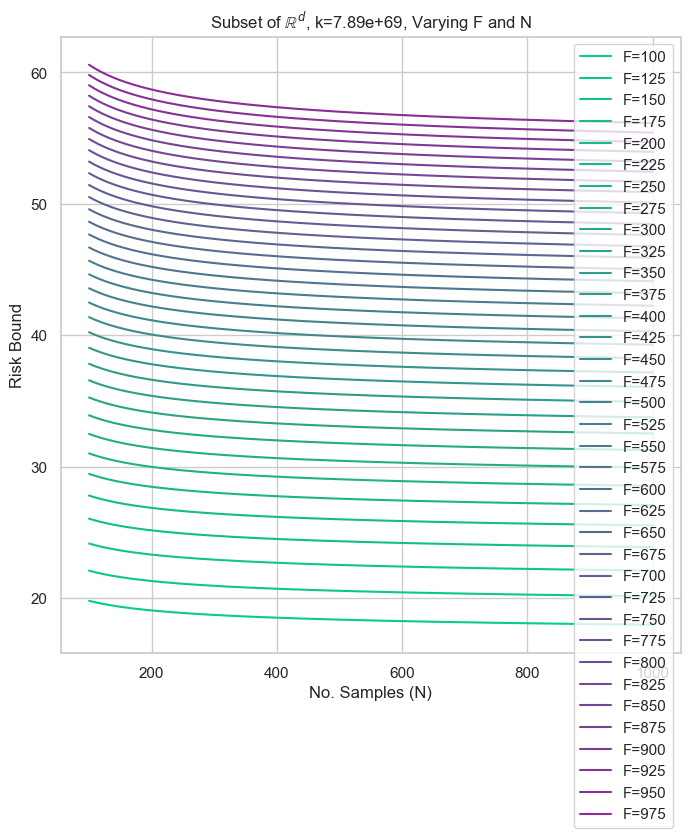

In [294]:
plt.figure(figsize=(8,8))
sns.set_style("whitegrid")

plt.title(''+dist_name+', k='+str('{:.2e}'.format(k))+', Varying F and N')

    
plt.xlabel('No. Samples (N)')
plt.ylabel('Risk Bound')# on $\sup_{f\in \mathcal{F}}\,|\mathcal{R}(\hat{f})-\hat{\mathcal{R}}(\hat{f})|$')
# plt.ylabel('Bound on $\mathbb{E}[\mathcal{W}_1(\mathbb{P},\mathbb{P}^N)]$')

# Generate Plots
for i in indexing_set:
    # Set Value of F
    F_global = int(np.round(i,0))
    
    # Write Function of N only
    def get_risk_bound__NVar_scalar(N):
        return get_risk_bound__scalar(k=k_global,F=F_global,N=N)
    
    get_risk_bound__NVar = np.vectorize(get_risk_bound__NVar_scalar)
    
    # Compute Risk Bound
    Risk_Bounds = get_risk_bound__NVar_scalar(N_sequence)
    
    # Plot
    col_index = (i-min(indexing_set))/(max(indexing_set)+1)
    plt.plot(N_sequence, 
             Risk_Bounds,
             label = 'F='+str(F_global).format(i=i),
             color=colorFader(c1,c2,col_index))


plt.legend(loc='best')


plt.savefig('Experiments/Risk_Bound_F/WBenchmarks__NF_kis'+str(k_global)+'.pdf')
plt.show()

### Fixed N

In [233]:
# Set External Values of k and F
N_global = 10**5

F_min = 4
F_max = 10**5
F_tests = 50


# Generate Sequence of Number of Samples
F_sequence = np.linspace(F_min,F_max,F_tests)

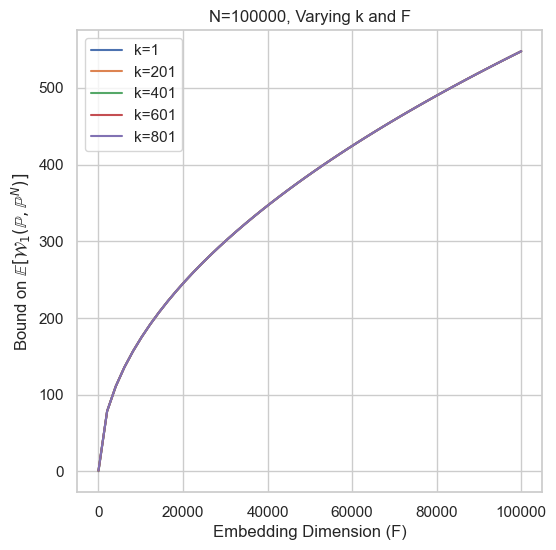

In [234]:
plt.figure(figsize=(6,6))

plt.title('N='+str(N_global)+', Varying k and F')
plt.xlabel('Embedding Dimension (F)')
plt.ylabel('Bound on $\mathbb{E}[\mathcal{W}_1(\mathbb{P},\mathbb{P}^N)]$')

for i in range(1,1000,200):
    # Set Value of F
    k_global = int(np.round(i,0))
    
    # Function of N only
    def get_risk_bound__NVar_scalar(F):
        return get_risk_bound__scalar(k=k_global,F=F,N=N_global)
    
    get_risk_bound__FVar = np.vectorize(get_risk_bound__NVar_scalar)
    
    # Compute Risk Bound
    Risk_Bounds = get_risk_bound__FVar(F_sequence)
    
    # Plot
    plt.plot(F_sequence, Risk_Bounds,label = 'k='+str(k_global).format(i=i))
    
plt.legend(loc='best')

# plt.savefig('kF_Nis'+str(N_global)+'.pdf')
plt.show()

## Best Bound As a Function of $Ratio=\frac{k}{N}$

### Search for Best Bound for a Given N

Use this code to estimate
$$
\inf_{m\in \mathbb{N}_+}\,
            L
            \operatorname{diam}(\mathcal{X}\times\mathcal{Y})
            \,
            \big(
            C_m
            \,
            (2\tau(\varphi)-1)\,
                \mathrm{rate}_m(N)
            \,
            +
            %%% Our magic value of epsilon
            \frac{
                    \ln(2/\delta)^{1/2}\tau(\varphi)
                }{
                    N^{1/2}
                }
        \big)
$$
This next code segment also returns the best representation dimension for the given $N$ and $k$.

In [ ]:
def find_best(k=k,N=N,bar_N=N,verbose=False,F_in=F_in):

    # Initialize Best Representation Dimension
    BEST_F = F_in[0]
    min_bound = get_risk_bound__scalar(N=N,k=k,F=F_in[0],distortion_known=distortion_given)
    
    # Search for Best Bound
    for F_loop in F_in:
        bound = get_risk_bound__scalar(N=N,k=k,F=F_loop,distortion_known=distortion_given)
        if verbose == True:
            print(bound)
        if bound < min_bound:
            min_bound = bound
            BEST_F = F_loop
    return BEST_F,min_bound

# print(F_in)
BEST_F = find_best(verbose=False)[0]
Tightest_Bound = find_best()[1]
print(BEST_F)
print(Tightest_Bound)

In [ ]:
def GET_BEST_F(kN_ratio):

    k = int(math.ceil(N**kN_ratio)) # power ratio
    
    BEST_F,min_bound = find_best(k=k)
    
    return BEST_F,min_bound

### Compute Best Ratios

In [ ]:
# Compute Best F as a function of ratio
Ratios = np.linspace(0.00001,2,10**1) # power-ratio
# best_F_ratio = GET_BEST_F(Ratios[0])[0] 
Optimal_F = [GET_BEST_F(ratio)[0] for ratio in Ratios]
print('Optimal F is:'+str(Optimal_F))

x_ratios = []
y_optimals = []
idx = 0
for i in Optimal_F:
    if i not in y_optimals:
        y_optimals.append(i)
        x_ratios.append(idx)
    idx += 1

### Plot Results

In [ ]:
plt.plot(x_ratios,y_optimals,color='purple')
plt.rcParams['text.usetex'] = True


# Labels
if Use_Power_Ratio == False:
    plt.title('Rate Parameter (F) as a Function of Ratio (k/N) (N='+str(format_e(Decimal(N)))+')')
    plt.xlabel("Ratio: N. Points in Space/N. Samples (k/N)")
else:
    plt.title(r'Rate Parameter (F) as a Function of the Ratio $\log_k(N)$ (N='+str(format_e(Decimal(N)))+')')
    plt.xlabel(r'$\log_k(N)$: N. Points in Space ($k$) vs. N. Samples ($N$)')
    
plt.ylabel("Rate Parameter (F)")
# plt.legend()

# ## Save and Show
if Use_Power_Ratio == False:
    # ## Save PDF
    plt.savefig('Experiments/Ratio_Plot/PDF/N'+str(N)+'.pdf')
    ## Save JPEG
    plt.savefig('Experiments/Ratio_Plot/JPG/N'+str(N)+'.jpg')
else:
    # ## Save PDF
    plt.savefig('Experiments/Ratio_Plot/PDF/Power_ratio_N'+str(N)+'.pdf')
    ## Save JPEG
    plt.savefig('Experiments/Ratio_Plot/JPG/Power_ratio_'+str(N)+'.jpg')
    
# ## PLOT
plt.show()

# Comparisons

In [ ]:
trivial_VCBound()

In [ ]:
## Get Main Plot
bound_terms = []
for F_loop in F_in:
    bound_terms.append(get_risk_bound__scalar(F=F_loop,k=k,N=N))
# Get VC and Hoeffding-type Benchmark in plotting form
VC_benchmark = np.repeat(trivial_VCBound(),np.array(bound_terms).shape[0])
Hoeffding_benchmark = np.repeat(Hoeffding_Bound(),np.array(bound_terms).shape[0])
## Verbosity:
print('VC/Occam Bound is:'+str(trivial_VCBound()))
print('Hoeffding-Type Bound is:'+str(Hoeffding_Bound()))
    
ax = plt.figure(figsize=(16,16))
sns.set_style("darkgrid")


axes1 = ax.add_axes([0.1, 0.1, 0.8, 0.8]) # main axes


# axes1.plot(wavelet_terms,color='orange', label = 'Local Embedding Cost',linewidth=4)
# axes1.plot(embedding_terms,color='blue',label = 'Global Embedding Quantity',linewidth=4)
axes1.plot(bound_terms,color='red', label = 'Bound',linewidth=4)
# axes1.plot(Hoeffding_benchmark,color='pink', label = 'Hoeffding-Bound',linewidth=4)
axes1.plot(VC_benchmark,color='purple', label = 'VC-Bound',linewidth=4,linestyle='dotted')
axes1.axvline(x=(BEST_F-1),label='Best F',linestyle="dashed")
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)


# Labels

plt.title('Best F: '+str(BEST_F-1)+' k = '+str('{:.2e}'.format(k))+' and N='+str('{:.2e}'.format(N)+'Tightest Bound ='+str(round(Tightest_Bound,3))),fontsize=25)
plt.xlabel("Value of F",fontsize=25)
plt.ylabel("Value of Risk-Bound",fontsize=25)
plt.legend(fontsize=20,loc='upper right')

# Get Zoomed Portion
## Near Best F
zoom_indices = np.array(range(max(1,BEST_F-2),min(BEST_F+3,F_in.shape[0])))
bound_terms__zoomed = np.array(bound_terms)[zoom_indices]
# VC_benchmark__zoomed
# Hoeffding_benchmark__zoomed

sns.set_style("whitegrid")
axes2 = ax.add_axes([0.55, 0.20, 0.3, 0.3]) # inset axes
axes2.set_title('Bound for Best F',fontsize=25)
# axes2.plot(zoom_indices,wavelet_terms__zoomed,color='orange', label = 'Local Embedding Cost',linewidth=4)
# axes2.plot(zoom_indices,embedding_terms__zoomed,color='blue',label = 'Global Embedding Quantity',linewidth=4)
axes2.plot(zoom_indices,bound_terms__zoomed,color='red', label = 'Bound',linewidth=4)
# axes2.plot(zoom_indices,VC_benchmark__zoomed,color='purple', label = 'VC-Bound',linewidth=4)
# axes2.plot(zoom_indices,Hoeffding_benchmark__zoomed,color='pink', label = 'Hoeffding-Bound',linewidth=4)
axes2.axvline(x=(BEST_F-1),linestyle="dashed")
plt.xlabel("Value of F",fontsize=20)
plt.ylabel("Value of Risk-Bound",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

## First time VC-Looses
### Identify first time the VC bound looses
Trivial_VC_looses = Hoeffding_benchmark>=bound_terms
Trivial_VC_looses = np.argmax(Trivial_VC_looses>0)
print('The VC and Hoeffding Bounds Loose above F='+str(Trivial_VC_looses))
indices_VC = np.array(range(Trivial_VC_looses,VC_benchmark.shape[0]))

### Generate Plot
# wavelet_terms__zoomed___VCComparison = np.array(wavelet_terms)[indices_VC]
# embedding_terms__zoomed___VCComparison = np.array(embedding_terms)[indices_VC]
bound_terms__zoomed___VCComparison = np.array(bound_terms)[indices_VC]
VC_benchmark_plot = VC_benchmark[indices_VC]
# Hoeffding_benchmark__zoomed___VCComparison = Hoeffding_benchmark[indices_VC]

# Hoeffding Comparison
# sns.set_style("ticks")
# axes2 = ax.add_axes([0.25, 0.55, 0.3, 0.3]) # inset axes
# axes2.set_title(r'Beats Hoeffding Bound for F$\geq$'+str(Trivial_VC_looses),fontsize=25)
# axes2.plot(indices_VC,bound_terms__zoomed___VCComparison,color='red', label = 'Bound',linewidth=4)
# # axes2.plot(indices_VC,VC_benchmark_plot,color='purple', label = 'VC-Bound',linewidth=4)
# axes2.plot(indices_VC,Hoeffding_benchmark__zoomed___VCComparison,color='pink', label = 'Hoeffding-Bound',linewidth=4)
# axes2.axvline(x=(BEST_F-1),linestyle="dashed")
# plt.xlabel("Value of F",fontsize=20)
# plt.ylabel("Value of Risk-Bound",fontsize=20)
# plt.xticks(fontsize=20)
# plt.yticks(fontsize=20)


# Save and Show
# if Tightest_Bound <= 1:
#     ## Save PDF
#     plt.savefig('Experiments/PDF/NonVac_BestF_'+str(BEST_F)+'____k'+str(k)+'___N'+str(N)+'.pdf')
#     ## Save JPEG
#     plt.savefig('Experiments/JPG/NonVac_BestF_'+str(BEST_F)+'____k'+str(k)+'___N'+str(N)+'.jpg')
# else:
#     ## Save PDF
#     plt.savefig('Experiments/PDF/BestF_'+str(BEST_F)+'____k'+str(k)+'___N'+str(N)+'.pdf')
#     ## Save JPEG
#     plt.savefig('Experiments/JPG/BestF_'+str(BEST_F)+'____k'+str(k)+'___N'+str(N)+'.jpg')
## PLOT
plt.show()

---
# Fin #
---